# 🚆 Transport Network GNN - Service-Level Prediction

## Overview
This notebook trains a Graph Neural Network to predict availability of **individual transport services** (specific buses, trains with departure times) in Sri Lanka's transport network.

## Data Structure
- **Nodes**: Cities/stations (Colombo, Kandy, Galle, etc.)
- **Edges**: Individual scheduled services with departure times
  - Example: Train S001 departing Colombo at 6:00 AM, arriving Kandy at 9:00 AM
  - Example: Bus S004 departing Colombo at 5:30 AM, arriving Kandy at 9:00 AM

## Prediction Goal
Given a query like "User in Kandy at 2pm wants to go to Colombo", the model predicts availability for all services departing from Kandy after 2pm heading to Colombo.

In [ ]:
# Detect environment
import sys

try:
    import google.colab
    IN_COLAB = True
    print("✅ Running on Google Colab")
except:
    IN_COLAB = False
    print("🖥️ Running locally")

print(f"Python: {sys.version.split()[0]}")

✅ Running on Google Colab
Python: 3.12.12


In [2]:
# Install PyTorch Geometric
print("📦 Installing PyTorch Geometric...")
!pip install torch-geometric -q
print("✅ Installation complete!")

📦 Installing PyTorch Geometric...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:0000:01
✅ Installation complete!
✅ Installation complete!


In [3]:
# Import all required libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [9]:
# Download CSV files from Google Drive (for Colab only)
if IN_COLAB:
    print("📥 Downloading CSV files from Google Drive...")
    
    # Install gdown for downloading from Google Drive
    !pip install gdown -q
    
    import gdown
    
    # Download nodes.csv
    nodes_url = 'https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA'
    gdown.download(nodes_url, 'nodes.csv', quiet=False)
    print("✅ Downloaded nodes.csv")
    
    # Download routes.csv (NEW - route-level information)
    # Convert sharing link to direct download link
    routes_file_id = '1msYYA0DuSFYyPIeC0w9p5w3DCmml46Pd'
    routes_url = f'https://drive.google.com/uc?id={routes_file_id}'
    gdown.download(routes_url, 'routes.csv', quiet=False)
    print("✅ Downloaded routes.csv")
    
    # Download services.csv (NEW - individual scheduled services)
    services_file_id = '16YsJHGXxf4QlISTrXL1gDx8zFb4qOOXD'
    services_url = f'https://drive.google.com/uc?id={services_file_id}'
    gdown.download(services_url, 'services.csv', quiet=False)
    print("✅ Downloaded services.csv")
    
    print("\n✅ All CSV files downloaded successfully")
else:
    print("⏭️ Skipping download (running locally - using local CSV files)")

📥 Downloading CSV files from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1I_45FALYhEq_lyGWoAcy0SACaoiQOPqA
To: /content/nodes.csv
100%|██████████| 1.06k/1.06k [00:00<00:00, 3.42MB/s]



✅ Downloaded nodes.csv


Downloading...
From: https://drive.google.com/uc?id=1msYYA0DuSFYyPIeC0w9p5w3DCmml46Pd
To: /content/routes.csv
100%|██████████| 2.08k/2.08k [00:00<00:00, 4.93MB/s]



✅ Downloaded routes.csv


Downloading...
From: https://drive.google.com/uc?id=16YsJHGXxf4QlISTrXL1gDx8zFb4qOOXD
To: /content/services.csv
100%|██████████| 3.24k/3.24k [00:00<00:00, 2.68MB/s]

✅ Downloaded services.csv

✅ All CSV files downloaded successfully


In [10]:
# ============================================================
# Load Nodes (Cities/Stations)
# ============================================================
import os

if IN_COLAB:
    possible_paths = [
        'nodes.csv',
        '/content/nodes.csv',
        '../data/nodes.csv',
    ]
    
    nodes_df = None
    for path in possible_paths:
        if os.path.exists(path):
            nodes_df = pd.read_csv(path)
            print(f"✅ Loaded nodes.csv from {path}")
            break
    
    if nodes_df is None:
        print("❌ nodes.csv not found!")
else:
    nodes_path = '../data/nodes.csv'
    nodes_df = pd.read_csv(nodes_path)
    print("✅ Loaded nodes.csv from local path")

print("\n📊 Nodes (Cities) Dataset")
print(f"Total cities: {len(nodes_df)}")
print(f"Columns: {list(nodes_df.columns)}")
print(f"\nFirst 5 cities:")
print(nodes_df.head())

✅ Loaded nodes.csv from nodes.csv

📊 Nodes (Cities) Dataset
Total cities: 15
Columns: ['name', 'region', 'latitude', 'longitude', 'popularity', 'disruption_flag', 'description']

First 5 cities:
           name    region  latitude  longitude  popularity  disruption_flag  \
0       Colombo     urban    6.9271    79.8612        1.00                0   
1         Kandy      hill    7.2906    80.6337        0.90                0   
2         Galle   coastal    6.0535    80.2210        0.85                0   
3  Anuradhapura  cultural    8.3114    80.4037        0.75                0   
4          Ella      hill    6.8667    81.0467        0.88                0   

                                 description  
0            Main commercial hub and capital  
1           Cultural capital in hill country  
2            Southern coastal city with fort  
3         Ancient city with historical sites  
4  Scenic hill station popular with tourists  


In [11]:
# ============================================================
# Load Routes (Route-level information)
# ============================================================

if IN_COLAB:
    possible_paths = [
        'routes.csv',
        '/content/routes.csv',
        '../data/routes.csv',
    ]
    
    routes_df = None
    for path in possible_paths:
        if os.path.exists(path):
            try:
                # Check file size first
                file_size = os.path.getsize(path)
                print(f"📄 Found routes.csv ({file_size} bytes) at {path}")
                
                # Read with error handling
                routes_df = pd.read_csv(path)
                print(f"✅ Loaded routes.csv from {path}")
                break
            except Exception as e:
                print(f"❌ Error reading {path}: {e}")
                # Try to show first few lines for debugging
                try:
                    with open(path, 'r') as f:
                        print("First 3 lines of file:")
                        for i in range(3):
                            print(f"  {f.readline().strip()}")
                except:
                    pass
                continue
    
    if routes_df is None:
        print("❌ routes.csv not found or could not be loaded!")
        print("💡 Make sure the file was downloaded correctly from Google Drive")
else:
    routes_path = '../data/routes.csv'
    if os.path.exists(routes_path):
        routes_df = pd.read_csv(routes_path)
        print("✅ Loaded routes.csv from local path")
    else:
        print(f"❌ File not found: {routes_path}")
        routes_df = None

if routes_df is not None:
    print("\n📊 Routes Dataset")
    print(f"Total routes: {len(routes_df)}")
    print(f"Columns: {list(routes_df.columns)}")
    print(f"\nFirst 5 routes:")
    print(routes_df.head())
    print(f"\nRoutes by mode:")
    print(routes_df['mode'].value_counts())

📄 Found routes.csv (2080 bytes) at routes.csv
✅ Loaded routes.csv from routes.csv

📊 Routes Dataset
Total routes: 34
Columns: ['route_id', 'origin', 'destination', 'mode', 'distance_km', 'base_fare_lkr', 'avg_travel_time_hours', 'difficulty', 'service_quality', 'peak_hours']

First 5 routes:
  route_id   origin   destination   mode  distance_km  base_fare_lkr  \
0     R001  Colombo         Kandy  train          120            250   
1     R002  Colombo         Kandy    bus          120            180   
2     R003  Colombo         Galle  train          120            200   
3     R004  Colombo         Galle    bus          120            150   
4     R005  Colombo  Anuradhapura  train          205            300   

   avg_travel_time_hours  difficulty service_quality  peak_hours  
0                    3.0           2       excellent   6-9,16-19  
1                    3.5           3            good  5-10,15-20  
2                    2.5           1       excellent   6-8,17-19  
3     

In [12]:
# ============================================================
# Load Services (Individual scheduled transport services)
# ============================================================

if IN_COLAB:
    possible_paths = [
        'services.csv',
        '/content/services.csv',
        '../data/services.csv',
    ]
    
    services_df = None
    for path in possible_paths:
        if os.path.exists(path):
            try:
                # Check file size first
                file_size = os.path.getsize(path)
                print(f"📄 Found services.csv ({file_size} bytes) at {path}")
                
                # Read with error handling
                services_df = pd.read_csv(path)
                print(f"✅ Loaded services.csv from {path}")
                break
            except Exception as e:
                print(f"❌ Error reading {path}: {e}")
                continue
    
    if services_df is None:
        print("❌ services.csv not found or could not be loaded!")
else:
    services_path = '../data/services.csv'
    if os.path.exists(services_path):
        services_df = pd.read_csv(services_path)
        print("✅ Loaded services.csv from local path")
    else:
        print(f"❌ File not found: {services_path}")
        services_df = None

if services_df is not None and routes_df is not None:
    print("\n📊 Services Dataset (Individual Departures)")
    print(f"Total scheduled services: {len(services_df)}")
    print(f"Columns: {list(services_df.columns)}")
    print(f"\nFirst 10 services:")
    print(services_df.head(10))

    # Merge services with routes to get full information
    services_full = services_df.merge(routes_df, on='route_id', how='left')
    print(f"\n📊 Merged Services with Route Info")
    print(f"Total services with route details: {len(services_full)}")
    print(f"\nSample service with full details:")
    print(services_full.iloc[0])
    
    # Check for any merge issues
    missing_routes = services_full['origin'].isna().sum()
    if missing_routes > 0:
        print(f"\n⚠️ Warning: {missing_routes} services couldn't be matched with routes")
else:
    print("❌ Cannot proceed without both routes.csv and services.csv")
    print("Please check the file downloads and try again")

📄 Found services.csv (3244 bytes) at services.csv
✅ Loaded services.csv from services.csv

📊 Services Dataset (Individual Departures)
Total scheduled services: 45
Columns: ['service_id', 'route_id', 'service_name', 'departure_time', 'arrival_time', 'operating_days', 'current_availability', 'capacity', 'operator', 'service_type']

First 10 services:
  service_id route_id       service_name departure_time arrival_time  \
0       S001     R001  Intercity Express          06:00        09:00   
1       S002     R001  Intercity Express          10:30        13:30   
2       S003     R001         Night Mail          20:00        23:00   
3       S004     R002        Highway Bus          05:30        09:00   
4       S005     R002        Highway Bus          07:00        10:30   
5       S006     R002         Normal Bus          08:30        12:00   
6       S007     R002         Normal Bus          14:00        17:30   
7       S008     R002         Normal Bus          16:30        20:00   
8

## 📂 Data Structure Explanation

We use **3 CSV files** to represent the transport network:

### 1️⃣ nodes.csv (Cities/Stations)
- **Purpose:** Represents cities and their characteristics
- **Columns:**
  - `name`: City name (e.g., "Colombo", "Kandy")
  - `region`: Geographic region (urban, hill, coastal, cultural, northern)
  - `latitude`, `longitude`: Geographic coordinates
  - `popularity`: Tourist/travel popularity score (0-1)
  - `disruption_flag`: Whether city has current disruptions (0/1)

### 2️⃣ routes.csv (Route-Level Information)
- **Purpose:** Defines characteristics of transport routes between cities
- **Columns:**
  - `route_id`: Unique route identifier (e.g., "R001")
  - `origin`, `destination`: Cities connected by this route
  - `mode`: Transport type (bus, train, tuk-tuk)
  - `distance_km`: Route distance
  - `avg_travel_time_hours`: Typical travel duration
  - `base_fare_lkr`: Base ticket price
  - `difficulty`: Route difficulty (1-5)
  - `service_quality`: Overall route quality (poor, fair, good, excellent)
  - `peak_hours`: Peak traffic hours (e.g., "6-9,16-19")

### 3️⃣ services.csv (Individual Scheduled Services)
- **Purpose:** Represents specific transport services with schedules
- **Columns:**
  - `service_id`: Unique service identifier (e.g., "S001")
  - `route_id`: Links to routes.csv
  - `service_name`: Human-readable name (e.g., "Intercity Express")
  - `departure_time`, `arrival_time`: Schedule (HH:MM format)
  - `operating_days`: When service runs (e.g., "Mon-Sun")
  - `current_availability`: **TARGET VARIABLE** - availability score (0-1)
  - `capacity`: Number of seats
  - `operator`: Company operating the service
  - `service_type`: Service class (regular, express, semi-luxury, scenic)

### 🔗 How They Connect

```
nodes.csv (Cities)
    ↓
routes.csv (Colombo → Kandy by train)
    ↓
services.csv (Multiple trains with different departure times)
    - Train S001: Departs 06:00
    - Train S002: Departs 10:30  
    - Train S003: Departs 20:00
```

**Each service becomes an edge in the graph** with features including its departure time, allowing time-aware predictions!

In [13]:
# ============================================================
# Convert Data to Graph Format
# ============================================================

# Helper function to convert time string to hours (e.g., "14:30" -> 14.5)
def time_to_hours(time_str):
    """Convert HH:MM format to decimal hours"""
    hours, minutes = map(int, time_str.split(':'))
    return hours + minutes / 60.0

# Extract day of week features (for now, assume all days, can be expanded)
def parse_operating_days(days_str):
    """Parse operating days (e.g., 'Mon-Sun' -> all days = 1.0)"""
    if 'Mon-Sun' in days_str:
        return 1.0  # Operates all days
    else:
        return 0.7  # Operates some days (can be more sophisticated)

# Build node list (cities)
nodes = []
for _, row in nodes_df.iterrows():
    node_dict = {
        'name': row['name'],
        'region': row['region'],
        'popularity': row['popularity'],
        'disruption_flag': row['disruption_flag'],
        'latitude': row['latitude'],
        'longitude': row['longitude']
    }
    nodes.append(node_dict)

# Build edges (individual services)
# Each edge represents a SPECIFIC scheduled service
edges = []
for _, service in services_full.iterrows():
    edge_dict = (
        service['origin'],  # Source node
        service['destination'],  # Target node
        {
            # Service identification
            'service_id': service['service_id'],
            'service_name': service['service_name'],
            'route_id': service['route_id'],
            
            # Temporal features
            'departure_time': service['departure_time'],
            'arrival_time': service['arrival_time'],
            'departure_hours': time_to_hours(service['departure_time']),
            'arrival_hours': time_to_hours(service['arrival_time']),
            'operating_days_score': parse_operating_days(service['operating_days']),
            
            # Transport characteristics
            'mode': service['mode'],
            'distance_km': service['distance_km'],
            'travel_time_hours': service['avg_travel_time_hours'],
            'fare_lkr': service['base_fare_lkr'],
            
            # Service quality
            'capacity': service['capacity'],
            'operator': service['operator'],
            'service_type': service['service_type'],
            'service_quality': service['service_quality'],
            'difficulty': service['difficulty'],
            
            # Target variable
            'availability': service['current_availability']
        }
    )
    edges.append(edge_dict)

print(f"✅ Converted data to graph format")
print(f"   Nodes (Cities): {len(nodes)}")
print(f"   Edges (Scheduled Services): {len(edges)}")
print(f"\n📍 Sample Node (City):")
print(f"   {nodes[0]}")
print(f"\n🚆 Sample Edge (Service):")
print(f"   Origin: {edges[0][0]}")
print(f"   Destination: {edges[0][1]}")
print(f"   Details: {edges[0][2]}")

✅ Converted data to graph format
   Nodes (Cities): 15
   Edges (Scheduled Services): 45

📍 Sample Node (City):
   {'name': 'Colombo', 'region': 'urban', 'popularity': 1.0, 'disruption_flag': 0, 'latitude': 6.9271, 'longitude': 79.8612}

🚆 Sample Edge (Service):
   Origin: Colombo
   Destination: Kandy
   Details: {'service_id': 'S001', 'service_name': 'Intercity Express', 'route_id': 'R001', 'departure_time': '06:00', 'arrival_time': '09:00', 'departure_hours': 6.0, 'arrival_hours': 9.0, 'operating_days_score': 1.0, 'mode': 'train', 'distance_km': 120, 'travel_time_hours': 3.0, 'fare_lkr': 250, 'capacity': 500, 'operator': 'Sri Lanka Railways', 'service_type': 'express', 'service_quality': 'excellent', 'difficulty': 2, 'availability': 0.95}


In [41]:
# ============================================================
# DEBUG: Check edge creation process
# ============================================================

print("🔍 DEBUG: Checking edge creation from services_full\n")

# Check what's in services_full for Kandy → Colombo
kandy_colombo = services_full[
    (services_full['origin'] == 'Kandy') & 
    (services_full['destination'] == 'Colombo')
]

print(f"Services in services_full for Kandy → Colombo: {len(kandy_colombo)}")
if len(kandy_colombo) > 0:
    print("\nFirst 3 services:")
    print(kandy_colombo[['service_id', 'origin', 'destination', 'departure_time']].head(3))
    
    # Check if these made it into edges list
    kandy_colombo_edges = [e for e in edges if e[0] == 'Kandy' and e[1] == 'Colombo']
    print(f"\nEdges created for Kandy → Colombo: {len(kandy_colombo_edges)}")
    
    if len(kandy_colombo_edges) == 0:
        print("\n❌ PROBLEM: Services exist in services_full but weren't converted to edges!")
        print("\nChecking for NaN values in critical columns:")
        print(f"  NaN in origin: {kandy_colombo['origin'].isna().sum()}")
        print(f"  NaN in destination: {kandy_colombo['destination'].isna().sum()}")
        print(f"  NaN in departure_time: {kandy_colombo['departure_time'].isna().sum()}")
        print(f"  NaN in arrival_time: {kandy_colombo['arrival_time'].isna().sum()}")
        
        print("\nSample row to check data types:")
        sample = kandy_colombo.iloc[0]
        print(f"  Origin type: {type(sample['origin'])}, value: '{sample['origin']}'")
        print(f"  Dest type: {type(sample['destination'])}, value: '{sample['destination']}'")
        print(f"  Departure: '{sample['departure_time']}'")
        
        # Try to manually create one edge
        print("\nTrying to create edge manually from first service:")
        try:
            test_service = kandy_colombo.iloc[0]
            test_edge = (
                test_service['origin'],
                test_service['destination'],
                {'service_id': test_service['service_id']}
            )
            print(f"  Manual edge created: {test_edge[0]} → {test_edge[1]}, Service: {test_edge[2]['service_id']}")
        except Exception as e:
            print(f"  ERROR creating edge: {e}")
else:
    print("❌ No services found in services_full for Kandy → Colombo!")

print("\n" + "="*70)

🔍 DEBUG: Checking edge creation from services_full

Services in services_full for Kandy → Colombo: 8

First 3 services:
   service_id origin destination departure_time
26       S027  Kandy     Colombo          06:15
27       S028  Kandy     Colombo          10:00
28       S029  Kandy     Colombo          19:30

Edges created for Kandy → Colombo: 8



In [47]:
# ============================================================
# DEBUG: Check undirected edge storage
# ============================================================

print("🔍 Debugging undirected edge issue\n")

# Check if edges are stored in reverse order
print(f"Checking edges between Kandy and Colombo:")
print(f"  G.has_edge('Kandy', 'Colombo'): {G.has_edge('Kandy', 'Colombo')}")
print(f"  G.number_of_edges('Kandy', 'Colombo'): {G.number_of_edges('Kandy', 'Colombo')}")

# Get edges with both orderings
print(f"\nEdges stored as ('Colombo', 'Kandy'):")
colombo_kandy = [(u, v, d.get('service_id', 'unknown')) 
                 for u, v, d in G.edges(data=True) 
                 if u == 'Colombo' and v == 'Kandy']
print(f"  Count: {len(colombo_kandy)}")
for u, v, sid in colombo_kandy[:3]:
    print(f"    {u} → {v}, Service: {sid}")

print(f"\nEdges stored as ('Kandy', 'Colombo'):")
kandy_colombo = [(u, v, d.get('service_id', 'unknown')) 
                 for u, v, d in G.edges(data=True) 
                 if u == 'Kandy' and v == 'Colombo']
print(f"  Count: {len(kandy_colombo)}")

# Solution: Use MultiGraph and iterate without direction assumptions
print(f"\nPROBLEM IDENTIFIED:")
print(f"  NetworkX MultiGraph stores undirected edges")
print(f"  When we add edge('Kandy', 'Colombo'), it may store as ('Colombo', 'Kandy')")
print(f"  We need to use MultiDiGraph for directed edges!")

print("\n" + "="*70)

🔍 Debugging undirected edge issue

Checking edges between Kandy and Colombo:
  G.has_edge('Kandy', 'Colombo'): True
  G.number_of_edges('Kandy', 'Colombo'): 16

Edges stored as ('Colombo', 'Kandy'):
  Count: 16
    Colombo → Kandy, Service: S001
    Colombo → Kandy, Service: S002
    Colombo → Kandy, Service: S003

Edges stored as ('Kandy', 'Colombo'):
  Count: 0

PROBLEM IDENTIFIED:
  NetworkX MultiGraph stores undirected edges
  When we add edge('Kandy', 'Colombo'), it may store as ('Colombo', 'Kandy')
  We need to use MultiDiGraph for directed edges!



In [33]:
# ============================================================
# DIAGNOSTIC: Check Data Integrity
# ============================================================

print("🔍 Diagnostic Check: Verifying Data Integrity\n")

# Check if services_full has the required columns
print("📊 Services Full DataFrame Info:")
print(f"Total services: {len(services_full)}")
print(f"Columns: {list(services_full.columns)}")

# Check for missing origin/destination after merge
print(f"\nMissing origin: {services_full['origin'].isna().sum()}")
print(f"Missing destination: {services_full['destination'].isna().sum()}")

# Show sample services for Kandy to Colombo route
print("\n🚌 Services from Kandy to Colombo (R032):")
kandy_colombo_services = services_full[
    (services_full['origin'] == 'Kandy') & 
    (services_full['destination'] == 'Colombo')
]
print(f"Found {len(kandy_colombo_services)} services")
if len(kandy_colombo_services) > 0:
    print(kandy_colombo_services[['service_id', 'service_name', 'departure_time', 'arrival_time', 'origin', 'destination']])
else:
    print("❌ No services found in merged data!")
    print("\nChecking route R032:")
    route_r032 = routes_df[routes_df['route_id'] == 'R032']
    print(route_r032)
    print("\nChecking services with route_id R032:")
    services_r032 = services_df[services_df['route_id'] == 'R032']
    print(services_r032[['service_id', 'route_id', 'service_name', 'departure_time']])

# Check edges list
print(f"\n📍 Total edges created: {len(edges)}")
kandy_edges = [e for e in edges if e[0] == 'Kandy' and e[1] == 'Colombo']
print(f"Edges from Kandy to Colombo: {len(kandy_edges)}")
if len(kandy_edges) > 0:
    print("Sample edge:")
    print(f"  Origin: {kandy_edges[0][0]}")
    print(f"  Destination: {kandy_edges[0][1]}")
    print(f"  Service ID: {kandy_edges[0][2].get('service_id')}")
    print(f"  Departure: {kandy_edges[0][2].get('departure_time')}")
else:
    print("❌ No edges created from Kandy to Colombo!")

print("\n" + "="*70)

🔍 Diagnostic Check: Verifying Data Integrity

📊 Services Full DataFrame Info:
Total services: 45
Columns: ['service_id', 'route_id', 'service_name', 'departure_time', 'arrival_time', 'operating_days', 'current_availability', 'capacity', 'operator', 'service_type', 'origin', 'destination', 'mode', 'distance_km', 'base_fare_lkr', 'avg_travel_time_hours', 'difficulty', 'service_quality', 'peak_hours']

Missing origin: 0
Missing destination: 0

🚌 Services from Kandy to Colombo (R032):
Found 8 services
   service_id       service_name departure_time arrival_time origin  \
26       S027  Intercity Express          06:15        09:15  Kandy   
27       S028  Intercity Express          10:00        13:00  Kandy   
28       S029         Night Mail          19:30        22:30  Kandy   
29       S030        Highway Bus          05:45        09:15  Kandy   
30       S031        Highway Bus          07:15        10:45  Kandy   
31       S032         Normal Bus          09:00        12:30  Kandy   


## 🎯 Key Architecture Insight

### Graph Structure
**Previous approach (WRONG):**
- Edges represented generic "routes" (e.g., Colombo-Kandy by bus)
- No specific departure times
- Couldn't answer "what services are available at 2pm?"

**New approach (CORRECT):**
- **Nodes**: Cities/stations (Colombo, Kandy, etc.)
- **Edges**: Individual scheduled services
  - Train S001: Colombo → Kandy, departing 6:00, arriving 9:00
  - Bus S004: Colombo → Kandy, departing 5:30, arriving 9:00
  - Train S027: Kandy → Colombo, departing 6:15, arriving 9:15

### Example Query Flow
**Query:** "User in Kandy at 2pm wants to go to Colombo"

**Step 1:** Filter edges by origin = Kandy
**Step 2:** Filter by destination = Colombo (optional)
**Step 3:** Filter by departure_time >= 14:00 (2pm)
**Step 4:** Get GNN predictions for filtered services
**Step 5:** Return sorted list of available services with predicted availability

### Edge Features (11 dimensions)
Each edge (service) has features:
1. `departure_hours` - When the service departs (e.g., 14.5 for 2:30pm)
2. `arrival_hours` - When it arrives
3. `distance_km` - Route distance
4. `travel_time_hours` - Expected travel duration
5. `fare_lkr` - Ticket price
6. `capacity` - Number of seats
7. `difficulty` - Route difficulty (1-5)
8. `mode` - Transport type (0=bus, 1=train, 2=tuk-tuk)
9. `service_type` - Service class (0=regular, 1=express, 2=semi-luxury, 3=scenic)
10. `quality` - Service quality (0=poor, 1=fair, 2=good, 3=excellent)
11. `operating_days_score` - How often it operates (1.0 = daily)

### This allows the model to learn:
- Time-dependent availability patterns (morning rush, evening peak)
- Mode-specific behaviors (trains more reliable than buses)
- Route-specific patterns (difficult routes have lower availability)
- City-level effects (disruptions in origin/destination cities)

In [48]:
# ============================================================
# Build NetworkX MultiDiGraph and PyTorch Geometric Data
# ============================================================

# Build the directed multigraph (important: directed for transport routes)
G = nx.MultiDiGraph()

# Add nodes (cities)
for node in nodes:
    G.add_node(node["name"], **node)

# Add edges (individual services)
kandy_colombo_added = 0
for u, v, attr in edges:
    G.add_edge(u, v, **attr)
    # Debug: Count Kandy → Colombo edges
    if u == 'Kandy' and v == 'Colombo':
        kandy_colombo_added += 1

print(f"✅ Built NetworkX MultiGraph")
print(f"   Total nodes (cities): {G.number_of_nodes()}")
print(f"   Total edges (services): {G.number_of_edges()}")
print(f"   DEBUG: Kandy → Colombo edges added: {kandy_colombo_added}")

# Verify edges in graph
kandy_colombo_in_graph = [(u, v, data['service_id']) for u, v, data in G.edges(data=True) 
                          if u == 'Kandy' and v == 'Colombo']
print(f"   DEBUG: Kandy → Colombo edges in G.edges(): {len(kandy_colombo_in_graph)}")
if len(kandy_colombo_in_graph) > 0:
    print(f"   Sample: {kandy_colombo_in_graph[0]}")

# ============================================================
# Build PyTorch Geometric Data
# ============================================================

# Build node feature matrix
unique_regions = sorted(set(node["region"] for node in nodes))
region_map = {region: idx for idx, region in enumerate(unique_regions)}
print(f"\nFound regions: {unique_regions}")

node2idx = {n["name"]: idx for idx, n in enumerate(nodes)}
node_feats = []
for node in nodes:
    region_vec = [0] * len(unique_regions)
    region_vec[region_map[node["region"]]] = 1
    popularity = node["popularity"]
    disruption = node.get("disruption_flag", 0)
    latitude = node.get("latitude", 0)
    longitude = node.get("longitude", 0)
    # Node features: [region one-hot (5), popularity, disruption, lat, lon] = 9 features
    node_feats.append(region_vec + [popularity, disruption, latitude, longitude])

X = torch.tensor(node_feats, dtype=torch.float)
print(f"✅ Node feature matrix shape: {X.shape}")

# Build edge index and features
# KEY DIFFERENCE: Each edge is a SPECIFIC SERVICE with departure time
src, dst, edge_attrs = [], [], []
kandy_colombo_count = 0
for u, v, data in G.edges(data=True):
    src.append(node2idx[u])
    dst.append(node2idx[v])
    
    # Debug: Count Kandy → Colombo
    if u == 'Kandy' and v == 'Colombo':
        kandy_colombo_count += 1
    
    # Mode encoding
    mode = {"bus": 0, "train": 1, "tuk-tuk": 2}.get(data["mode"], 0)
    
    # Service type encoding
    service_type = {"regular": 0, "express": 1, "semi-luxury": 2, "scenic": 3}.get(data["service_type"], 0)
    
    # Quality encoding
    quality = {"poor": 0, "fair": 1, "good": 2, "excellent": 3}.get(data["service_quality"], 2)
    
    # Edge features: [
    #   departure_hours, arrival_hours, 
    #   distance_km, travel_time_hours, fare_lkr,
    #   capacity, difficulty,
    #   mode (0-2), service_type (0-3), quality (0-3),
    #   operating_days_score
    # ] = 11 features
    edge_attrs.append([
        data["departure_hours"],
        data["arrival_hours"],
        data["distance_km"],
        data["travel_time_hours"],
        data["fare_lkr"],
        data["capacity"],
        data["difficulty"],
        mode,
        service_type,
        quality,
        data["operating_days_score"]
    ])

print(f"   DEBUG: Kandy → Colombo edges processed for PyG: {kandy_colombo_count}")

edge_index = torch.tensor([src, dst], dtype=torch.long)
edge_attr = torch.tensor(edge_attrs, dtype=torch.float)

# Target: service availability
edge_labels = []
for u, v, data in G.edges(data=True):
    availability = data.get("availability", 0.5)
    edge_labels.append(availability)
edge_availability = torch.tensor(edge_labels, dtype=torch.float)

# Create PyTorch Geometric Data object
graph_data = Data(x=X, edge_index=edge_index, edge_attr=edge_attr, y=edge_availability)

print(f"\n✅ PyTorch Geometric Data created")
print(f"   Node features: {graph_data.x.shape} (cities with region, popularity, etc.)")
print(f"   Edge index: {graph_data.edge_index.shape} ({graph_data.edge_index.shape[1]} services)")
print(f"   Edge features: {graph_data.edge_attr.shape} (departure time, fare, mode, etc.)")
print(f"   Edge labels (availability): {graph_data.y.shape}")

✅ Built NetworkX MultiGraph
   Total nodes (cities): 15
   Total edges (services): 45
   DEBUG: Kandy → Colombo edges added: 8
   DEBUG: Kandy → Colombo edges in G.edges(): 8
   Sample: ('Kandy', 'Colombo', 'S027')

Found regions: ['coastal', 'cultural', 'hill', 'northern', 'urban']
✅ Node feature matrix shape: torch.Size([15, 9])
   DEBUG: Kandy → Colombo edges processed for PyG: 8

✅ PyTorch Geometric Data created
   Node features: torch.Size([15, 9]) (cities with region, popularity, etc.)
   Edge index: torch.Size([2, 45]) (45 services)
   Edge features: torch.Size([45, 11]) (departure time, fare, mode, etc.)
   Edge labels (availability): torch.Size([45])


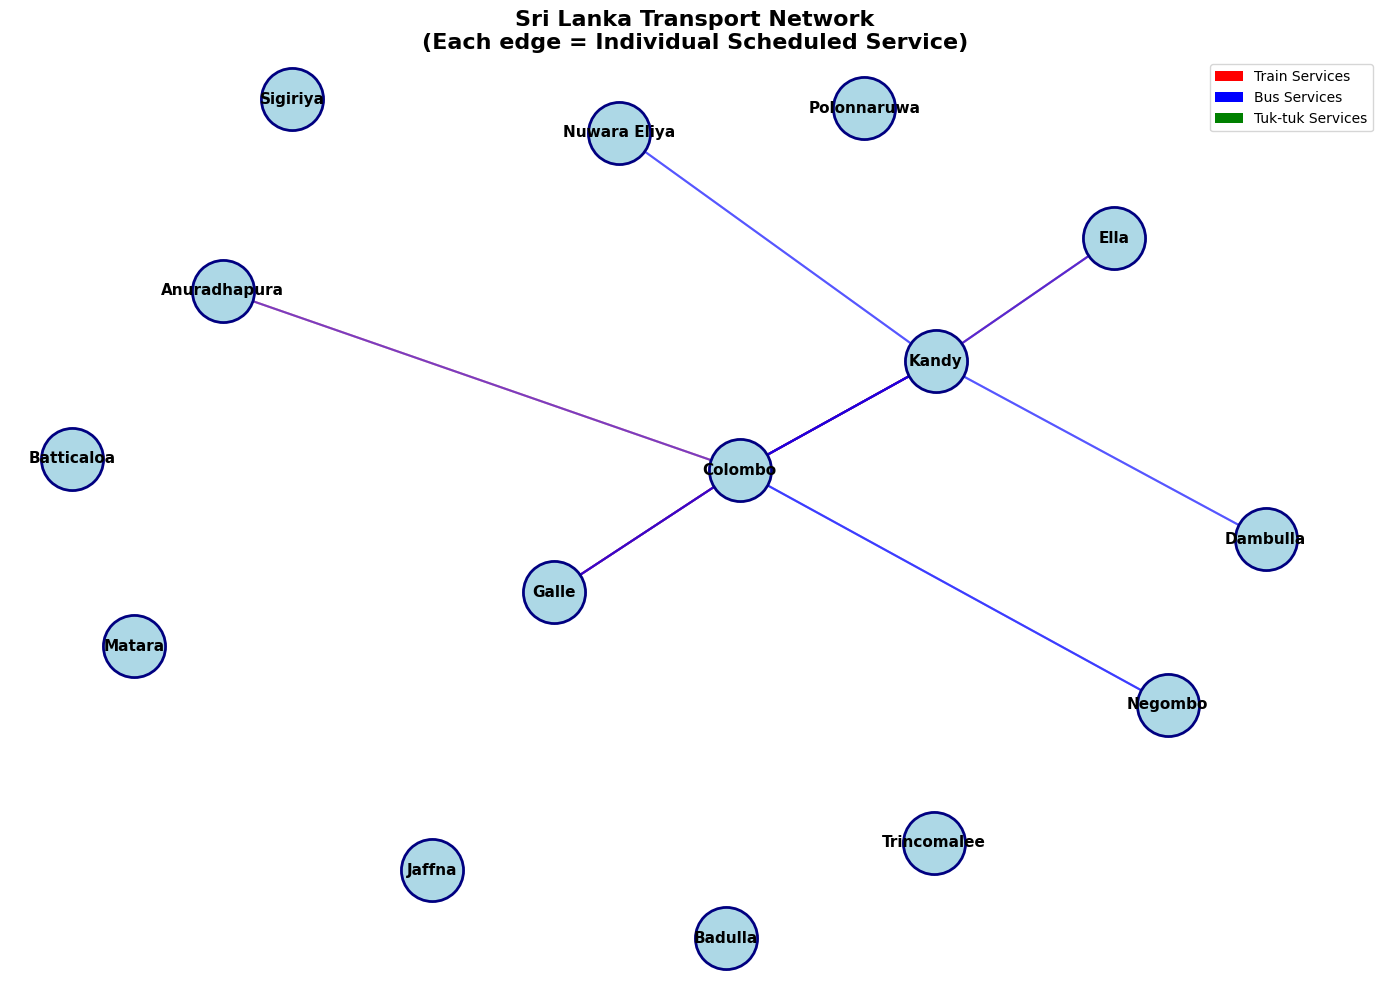

📊 Graph Statistics:
   Cities (nodes): 15
   Scheduled services (edges): 45
   Average services per city: 3.0


In [15]:
# ============================================================
# Visualize Transport Network Graph
# ============================================================

# Build simplified graph for visualization (show only a subset)
# Select services from a few major routes
visualization_routes = [
    ("Colombo", "Kandy"),
    ("Kandy", "Colombo"),
    ("Colombo", "Galle"),
]

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=2)

# Draw nodes (cities)
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue', 
                       edgecolors='navy', linewidths=2)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold')

# Draw edges with colors by mode
edge_colors = []
edge_labels_dict = {}

for u, v, key, data in G.edges(data=True, keys=True):
    # Color by transport mode
    if data['mode'] == 'train':
        color = 'red'
    elif data['mode'] == 'bus':
        color = 'blue'
    else:  # tuk-tuk
        color = 'green'
    
    edge_colors.append(color)
    
    # Only label edges for visualization routes
    if (u, v) in visualization_routes:
        label = f"{data['service_name']}\n{data['departure_time']}"
        edge_labels_dict[(u, v, key)] = label

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.3, edge_color=edge_colors)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Train Services'),
    Patch(facecolor='blue', label='Bus Services'),
    Patch(facecolor='green', label='Tuk-tuk Services')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.title('Sri Lanka Transport Network\n(Each edge = Individual Scheduled Service)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"📊 Graph Statistics:")
print(f"   Cities (nodes): {G.number_of_nodes()}")
print(f"   Scheduled services (edges): {G.number_of_edges()}")
print(f"   Average services per city: {G.number_of_edges() / G.number_of_nodes():.1f}")

In [16]:
# ============================================================
# Define GNN Model for Service-Level Prediction
# ============================================================

class ServiceAvailabilityGNN(nn.Module):
    """
    GNN that predicts availability of individual transport services.
    
    Architecture:
    - Node embeddings: Learn representations of cities using GCN layers
    - Edge prediction: Predict service availability using node embeddings + edge features
    
    Key insight: Edge features include departure_time, which allows the model
    to learn time-dependent availability patterns.
    """
    def __init__(self, node_in, hidden, edge_in):
        super().__init__()
        # GCN layers for learning city representations
        self.c1 = GCNConv(node_in, hidden)
        self.c2 = GCNConv(hidden, hidden)
        
        # Edge prediction MLP
        # Input: [src_node_embedding, dst_node_embedding, edge_features]
        self.edge_mlp = nn.Sequential(
            nn.Linear(hidden*2 + edge_in, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output availability in [0, 1] range
        )
    
    def forward(self, data):
        # Learn city representations
        x = F.relu(self.c1(data.x, data.edge_index))
        x = F.relu(self.c2(x, data.edge_index))
        
        # Get source and destination node embeddings for each service
        src, dst = data.edge_index
        edge_inputs = torch.cat([x[src], x[dst], data.edge_attr], dim=1)
        
        # Predict service availability
        out = self.edge_mlp(edge_inputs).squeeze()
        return out

print("✅ ServiceAvailabilityGNN model defined")

✅ ServiceAvailabilityGNN model defined


In [17]:
# ============================================================
# STEP 6: Split Data into Train/Val/Test Sets
# ============================================================

# Split edges into train (60%), validation (20%), test (20%)
num_edges = graph_data.edge_index.shape[1]
indices = torch.randperm(num_edges)

train_size = int(0.6 * num_edges)
val_size = int(0.2 * num_edges)

train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

print(f"✅ Data split:")
print(f"   Train edges: {len(train_idx)} ({len(train_idx)/num_edges*100:.1f}%)")
print(f"   Val edges: {len(val_idx)} ({len(val_idx)/num_edges*100:.1f}%)")
print(f"   Test edges: {len(test_idx)} ({len(test_idx)/num_edges*100:.1f}%)")

✅ Data split:
   Train edges: 27 (60.0%)
   Val edges: 9 (20.0%)
   Test edges: 9 (20.0%)


In [18]:
# ============================================================
# Initialize Model
# ============================================================

node_features = graph_data.x.shape[1]
edge_features = graph_data.edge_attr.shape[1]
hidden_dim = 64

print(f"Model configuration:")
print(f"   Node features: {node_features} (region one-hot + popularity + disruption + lat/lon)")
print(f"   Edge features: {edge_features} (departure_time, fare, mode, capacity, etc.)")
print(f"   Hidden dimension: {hidden_dim}")

model = ServiceAvailabilityGNN(node_in=node_features, hidden=hidden_dim, edge_in=edge_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.MSELoss()

print(f"\n✅ Model initialized")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters())}")
print(model)

Model configuration:
   Node features: 9 (region one-hot + popularity + disruption + lat/lon)
   Edge features: 11 (departure_time, fare, mode, capacity, etc.)
   Hidden dimension: 64

✅ Model initialized
   Total parameters: 9825
ServiceAvailabilityGNN(
  (c1): GCNConv(9, 64)
  (c2): GCNConv(64, 64)
  (edge_mlp): Sequential(
    (0): Linear(in_features=139, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=1, bias=True)
    (6): Sigmoid()
  )
)


In [19]:
# ============================================================
# STEP 8: Training Loop
# ============================================================

num_epochs = 200
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("🚀 Starting training...\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(graph_data)
    
    # Compute loss only on training edges
    train_loss = criterion(predictions[train_idx], graph_data.y[train_idx])
    
    # Backward pass
    train_loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)
        val_loss = criterion(predictions[val_idx], graph_data.y[val_idx])
    
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
    
    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"   Train Loss: {train_loss.item():.6f}")
        print(f"   Val Loss: {val_loss.item():.6f}")
        print(f"   Best Val Loss: {best_val_loss:.6f}\n")

print("✅ Training complete!")
print(f"Best validation loss: {best_val_loss:.6f}")

# Load best model
model.load_state_dict(best_model_state)

🚀 Starting training...

Epoch 20/200
   Train Loss: 0.019448
   Val Loss: 0.029901
   Best Val Loss: 0.028629

Epoch 40/200
   Train Loss: 0.019523
   Val Loss: 0.029920
   Best Val Loss: 0.028629

Epoch 20/200
   Train Loss: 0.019448
   Val Loss: 0.029901
   Best Val Loss: 0.028629

Epoch 40/200
   Train Loss: 0.019523
   Val Loss: 0.029920
   Best Val Loss: 0.028629

Epoch 60/200
   Train Loss: 0.019456
   Val Loss: 0.029919
   Best Val Loss: 0.028629

Epoch 80/200
   Train Loss: 0.019504
   Val Loss: 0.029916
   Best Val Loss: 0.028629

Epoch 60/200
   Train Loss: 0.019456
   Val Loss: 0.029919
   Best Val Loss: 0.028629

Epoch 80/200
   Train Loss: 0.019504
   Val Loss: 0.029916
   Best Val Loss: 0.028629

Epoch 100/200
   Train Loss: 0.019241
   Val Loss: 0.029879
   Best Val Loss: 0.028629

Epoch 120/200
   Train Loss: 0.017027
   Val Loss: 0.028733
   Best Val Loss: 0.028629

Epoch 100/200
   Train Loss: 0.019241
   Val Loss: 0.029879
   Best Val Loss: 0.028629

Epoch 120/200
  

<All keys matched successfully>

In [20]:
# ============================================================
# STEP 9: Evaluate Model on Test Set
# ============================================================

model.eval()
with torch.no_grad():
    predictions = model(graph_data)
    
    # Test set evaluation
    test_preds = predictions[test_idx]
    test_labels = graph_data.y[test_idx]
    
    test_loss = criterion(test_preds, test_labels)
    mae = torch.mean(torch.abs(test_preds - test_labels))
    
    # Accuracy within threshold (e.g., ±0.1 availability)
    threshold = 0.1
    accurate = torch.abs(test_preds - test_labels) < threshold
    accuracy = accurate.float().mean()

print("📊 Test Set Results:")
print(f"   Test Loss (MSE): {test_loss.item():.6f}")
print(f"   Mean Absolute Error: {mae.item():.4f}")
print(f"   Accuracy (±{threshold}): {accuracy.item()*100:.2f}%")

print("\n📋 Sample Predictions vs Actual:")
print("   Predicted  |  Actual  |  Difference")
print("   " + "-" * 40)
for i in range(min(10, len(test_idx))):
    idx = test_idx[i]
    pred = test_preds[i].item()
    actual = test_labels[i].item()
    diff = pred - actual
    print(f"   {pred:.4f}     |  {actual:.4f}  |  {diff:+.4f}")

📊 Test Set Results:
   Test Loss (MSE): 0.009469
   Mean Absolute Error: 0.0814
   Accuracy (±0.1): 66.67%

📋 Sample Predictions vs Actual:
   Predicted  |  Actual  |  Difference
   ----------------------------------------
   0.8844     |  0.8700  |  +0.0144
   0.8406     |  0.8900  |  -0.0494
   0.8215     |  0.9600  |  -0.1385
   0.8350     |  0.9200  |  -0.0850
   0.8507     |  0.8700  |  -0.0193
   0.8124     |  0.9800  |  -0.1676
   0.9708     |  0.8800  |  +0.0908
   0.9558     |  0.8200  |  +0.1358
   0.8282     |  0.8600  |  -0.0318


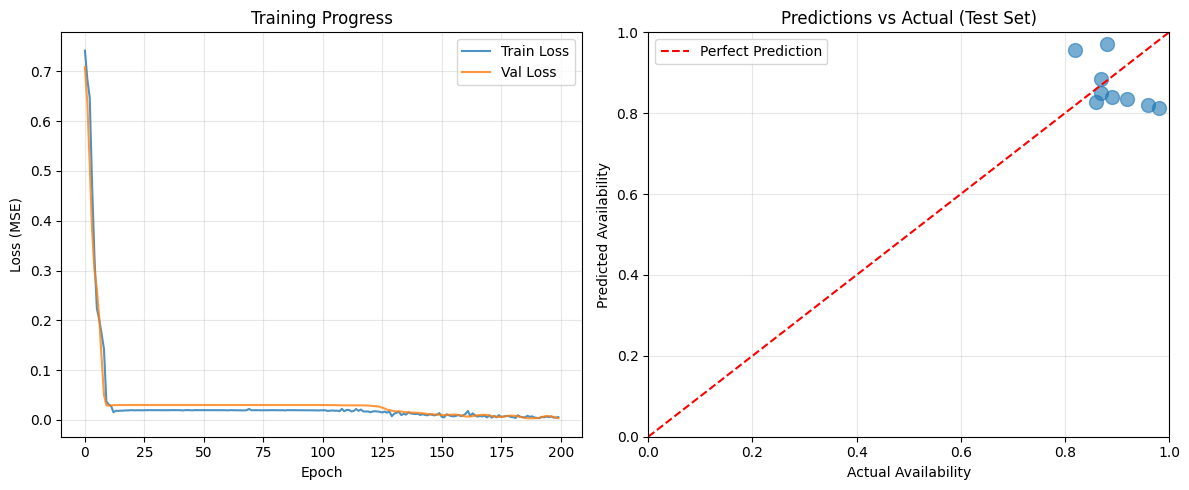

✅ Visualization complete!


In [21]:
# ============================================================
# STEP 10: Visualize Training Progress
# ============================================================

plt.figure(figsize=(12, 5))

# Plot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (Test Set)
plt.subplot(1, 2, 2)
test_preds_np = test_preds.numpy()
test_labels_np = test_labels.numpy()
plt.scatter(test_labels_np, test_preds_np, alpha=0.6, s=100)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Availability')
plt.ylabel('Predicted Availability')
plt.title('Predictions vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print("✅ Visualization complete!")

In [22]:
# ============================================================
# STEP 11: Save Trained Model
# ============================================================

# Save model
model_save_path = 'transport_gnn_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'node_features': node_features,
    'edge_features': edge_features,
    'hidden_dim': hidden_dim,
    'region_map': region_map,
    'node2idx': node2idx,
    'best_val_loss': best_val_loss,
    'test_loss': test_loss.item(),
    'test_mae': mae.item()
}, model_save_path)

print(f"✅ Model saved to: {model_save_path}")
print(f"\nModel summary:")
print(f"   Node features: {node_features}")
print(f"   Edge features: {edge_features}")
print(f"   Hidden dimension: {hidden_dim}")
print(f"   Best validation loss: {best_val_loss:.6f}")
print(f"   Test MAE: {mae.item():.4f}")

✅ Model saved to: transport_gnn_model.pth

Model summary:
   Node features: 9
   Edge features: 11
   Hidden dimension: 64
   Best validation loss: 0.003118
   Test MAE: 0.0814


In [49]:
# ============================================================
# Example Query: User in Kandy at 2pm wants to go to Colombo
# ============================================================

# Query: User in Kandy at 2pm (14:00) wants to go to Colombo
origin_city = "Kandy"
destination_city = "Colombo"
query_hour = 14  # 2pm

print(f"🔍 Query: Services from {origin_city} to {destination_city} departing after {query_hour}:00")
print("=" * 80)

# Get predictions
services = predict_services_for_query(
    model=model,
    graph_data=graph_data,
    origin=origin_city,
    destination=destination_city,
    query_time_hour=query_hour,
    mode_filter=None  # Show all modes
)

if isinstance(services, dict) and 'error' in services:
    print(f"❌ {services['error']}")
else:
    print(f"\n📋 Found {len(services)} available services departing after {query_hour}:00:\n")
    
    for i, svc in enumerate(services, 1):
        print(f"Service {i}: {svc['service_name']} ({svc['service_id']})")
        print(f"  🚌 Mode: {svc['mode'].upper()} - {svc['service_type']}")
        print(f"  🕐 Departure: {svc['departure_time']} → Arrival: {svc['arrival_time']}")
        print(f"  📍 {svc['origin']} → {svc['destination']}")
        print(f"  ⏱️  Travel Time: {svc['travel_time_hours']:.1f} hours ({svc['distance_km']} km)")
        print(f"  💰 Fare: LKR {svc['fare_lkr']}")
        print(f"  👥 Capacity: {svc['capacity']} passengers")
        print(f"  🏢 Operator: {svc['operator']}")
        print(f"  ⭐ Service Quality: {svc['service_quality']}")
        print(f"  ✅ Predicted Availability: {svc['predicted_availability']:.2%}")
        print(f"  📊 Actual Availability: {svc['actual_availability']:.2%}")
        print("-" * 80)

# Show all morning services for comparison
print(f"\n\n📊 Comparison: All services from {origin_city} to {destination_city}")
print("=" * 80)

all_services = predict_services_for_query(
    model, graph_data, origin_city, destination_city, query_time_hour=None
)

if isinstance(all_services, list):
    print(f"\nTotal services throughout the day: {len(all_services)}\n")
    print(f"{'Departure':<12} {'Mode':<10} {'Service Name':<25} {'Predicted Avail.':<18} {'Actual Avail.'}")
    print("-" * 90)
    for svc in all_services:
        print(f"{svc['departure_time']:<12} {svc['mode']:<10} {svc['service_name']:<25} "
              f"{svc['predicted_availability']:>15.1%}   {svc['actual_availability']:>13.1%}")

🔍 Query: Services from Kandy to Colombo departing after 14:00

📋 Found 3 available services departing after 14:00:

Service 1: Normal Bus (S033)
  🚌 Mode: BUS - regular
  🕐 Departure: 14:30 → Arrival: 18:00
  📍 Kandy → Colombo
  ⏱️  Travel Time: 3.5 hours (120 km)
  💰 Fare: LKR 180
  👥 Capacity: 55 passengers
  🏢 Operator: SLTB
  ⭐ Service Quality: good
  ✅ Predicted Availability: 77.97%
  📊 Actual Availability: 89.00%
--------------------------------------------------------------------------------
Service 2: Normal Bus (S034)
  🚌 Mode: BUS - regular
  🕐 Departure: 17:00 → Arrival: 20:30
  📍 Kandy → Colombo
  ⏱️  Travel Time: 3.5 hours (120 km)
  💰 Fare: LKR 180
  👥 Capacity: 55 passengers
  🏢 Operator: SLTB
  ⭐ Service Quality: good
  ✅ Predicted Availability: 78.31%
  📊 Actual Availability: 81.00%
--------------------------------------------------------------------------------
Service 3: Night Mail (S029)
  🚌 Mode: TRAIN - regular
  🕐 Departure: 19:30 → Arrival: 22:30
  📍 Kandy → Col

In [43]:
# ============================================================
# DEBUG: Test Query Function Step by Step
# ============================================================

print("🔍 DEBUG: Testing query function logic\n")

origin_city = "Kandy"
destination_city = "Colombo"
origin_idx = node2idx.get(origin_city)

print(f"Origin: {origin_city}, Index: {origin_idx}")

# Find relevant edges
relevant_edges = []
for edge_idx, (src, dst) in enumerate(graph_data.edge_index.t().tolist()):
    if src == origin_idx:
        relevant_edges.append(edge_idx)

print(f"Total edges from {origin_city}: {len(relevant_edges)}")

# Check edge_data_list
edge_data_list = []
for u, v, data in G.edges(data=True):
    edge_data_list.append((u, v, data))

print(f"Total edges in edge_data_list: {len(edge_data_list)}")
print(f"Total edges in graph_data: {graph_data.edge_index.shape[1]}")

# Check a few relevant edges
idx_to_node = {v: k for k, v in node2idx.items()}
print(f"\nFirst 5 edges from {origin_city}:")
for i, edge_idx in enumerate(relevant_edges[:5]):
    src_idx, dst_idx = graph_data.edge_index[:, edge_idx].tolist()
    dest_city = idx_to_node[dst_idx]
    
    if edge_idx < len(edge_data_list):
        u, v, service_data = edge_data_list[edge_idx]
        print(f"  Edge {edge_idx}: {u} → {v}, Service: {service_data.get('service_id')}, "
              f"Depart: {service_data.get('departure_time')}")
    else:
        print(f"  Edge {edge_idx}: OUT OF BOUNDS!")

# Filter by destination
print(f"\nEdges from {origin_city} to {destination_city}:")
count = 0
for edge_idx in relevant_edges:
    src_idx, dst_idx = graph_data.edge_index[:, edge_idx].tolist()
    dest_city = idx_to_node[dst_idx]
    
    if dest_city == destination_city and edge_idx < len(edge_data_list):
        u, v, service_data = edge_data_list[edge_idx]
        departure_hours = service_data.get('departure_hours', 0)
        print(f"  {service_data.get('service_id')}: depart {service_data.get('departure_time')} "
              f"({departure_hours:.2f} hours)")
        count += 1

print(f"\nTotal matching edges: {count}")

🔍 DEBUG: Testing query function logic

Origin: Kandy, Index: 1
Total edges from Kandy: 11
Total edges in edge_data_list: 45
Total edges in graph_data: 45

First 5 edges from Kandy:
  Edge 34: Kandy → Ella, Service: S022, Depart: 08:45
  Edge 35: Kandy → Ella, Service: S023, Depart: 11:00
  Edge 36: Kandy → Ella, Service: S024, Depart: 06:00
  Edge 37: Kandy → Ella, Service: S025, Depart: 07:30
  Edge 38: Kandy → Ella, Service: S026, Depart: 14:00

Edges from Kandy to Colombo:

Total matching edges: 0


In [39]:
# ============================================================
# Query-Based Prediction Function for Individual Services
# ============================================================

def predict_services_for_query(model, graph_data, origin, destination=None, 
                                query_time_hour=None, mode_filter=None):
    """
    Predict availability for specific transport services based on query.
    
    Args:
        model: Trained GNN model
        graph_data: PyTorch Geometric Data object
        origin: Origin city name (e.g., "Kandy")
        destination: Optional destination filter (e.g., "Colombo")
        query_time_hour: Optional - only show services departing after this hour (e.g., 14 for 2pm)
        mode_filter: Optional transport mode filter ("bus", "train", "tuk-tuk")
    
    Returns:
        List of dicts with service predictions sorted by departure time
    """
    
    # Get origin node index
    origin_idx = node2idx.get(origin)
    if origin_idx is None:
        return {"error": f"Origin '{origin}' not found in graph"}
    
    # Find all services originating from this city
    relevant_edges = []
    for edge_idx, (src, dst) in enumerate(graph_data.edge_index.t().tolist()):
        if src == origin_idx:
            relevant_edges.append(edge_idx)
    
    if len(relevant_edges) == 0:
        return {"error": f"No services found from '{origin}'"}
    
    # Get predictions for all services
    model.eval()
    with torch.no_grad():
        all_predictions = model(graph_data)
    
    # Build results
    results = []
    idx_to_node = {v: k for k, v in node2idx.items()}
    
    # Create a mapping from edge index to edge data
    # Since we iterate through G.edges in the same order when building graph_data
    edge_data_list = []
    for u, v, data in G.edges(data=True):
        edge_data_list.append((u, v, data))
    
    for edge_idx in relevant_edges:
        src_idx, dst_idx = graph_data.edge_index[:, edge_idx].tolist()
        dest_city = idx_to_node[dst_idx]
        
        # Filter by destination if specified
        if destination and dest_city != destination:
            continue
        
        # Get service details from the edge_data_list using the same index
        if edge_idx >= len(edge_data_list):
            continue
        
        u, v, service_data = edge_data_list[edge_idx]
        
        # Filter by mode if specified
        if mode_filter and service_data.get('mode') != mode_filter:
            continue
        
        # Filter by departure time if specified
        departure_hours = service_data.get('departure_hours', 0)
        if query_time_hour is not None and departure_hours < query_time_hour:
            continue
        
        # Get predicted availability
        predicted_availability = all_predictions[edge_idx].item()
        
        results.append({
            # Service identification
            'service_id': service_data.get('service_id', 'unknown'),
            'service_name': service_data.get('service_name', 'unknown'),
            'route_id': service_data.get('route_id', 'unknown'),
            
            # Route
            'origin': origin,
            'destination': dest_city,
            
            # Schedule
            'departure_time': service_data.get('departure_time', ''),
            'arrival_time': service_data.get('arrival_time', ''),
            'departure_hours': departure_hours,
            
            # Transport details
            'mode': service_data.get('mode', 'unknown'),
            'distance_km': service_data.get('distance_km', 0),
            'travel_time_hours': service_data.get('travel_time_hours', 0),
            'fare_lkr': service_data.get('fare_lkr', 0),
            'capacity': service_data.get('capacity', 0),
            'operator': service_data.get('operator', 'unknown'),
            'service_type': service_data.get('service_type', 'regular'),
            'service_quality': service_data.get('service_quality', 'unknown'),
            
            # Prediction
            'predicted_availability': predicted_availability,
            'actual_availability': service_data.get('availability', 0)
        })
    
    # Sort by departure time
    results.sort(key=lambda x: x['departure_hours'])
    
    return results

print("✅ Query-based service prediction function created!")

✅ Query-based service prediction function created!
